<a id='top'></a>
## Can Amazon Reviews Help Businesses Learn their Best Customers? 

#### Contributors: Muoyo Okome, Jill Carrie

<p><img src='../images/wordcloud.png' width=400>

<a id='toc'></a>
### Table of Contents
1. [Problem Statement](#problemstatement)
2. [Data Sources](#datasources)
3. [Data Cleaning](#datacleaning)
4. [Classification Analysis](#classification)  
    - [Logistic Regression](#logisticregression)
    - [K Nearest Neighbors](#kneighbors)
    - [Decision Trees](#decisiontrees)
    - [Bagged Trees](#baggedtrees)
    - [Random Forest](#randomforest)
    - [Adaboost](#adaboost)
    - [Gradient Boost](#gradientboost)
    - [Improved Results through Count Vectorization](#countvectorization)
5. [Vizualizations](#visualizations)
6. [Recommendations & Next Steps](#recommendations)

In [1]:
# Import necessary libraries
import warnings
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='problemstatement'></a>
### Problem Statement

**Can Amazon Reviews Help Businesses Learn their Best Customers?**

The key question we look to answer is whether knowing the text of an Amazon Customer Review can help us predict the star rating of that review.

Our goal is to eventually improve our process to a level where it can be deployed on customer conversations anywhere to help businesses identify customers most likely to love or hate their products based on the things they are saying.

[Back to Top ↑](#top)

<a id='datasources'></a>
### Data Sources

#### **[AWS Open Data: Amazon Customer Reviews Dataset](https://registry.opendata.aws/amazon:reviews/)**

- Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.

- A collection of reviews written in the Amazon.com marketplace and associated metadata from 1995 until 2015. This is intended to facilitate study into the properties (and the evolution) of customer reviews potentially including how people evaluate and express their experiences with respect to products at scale. (130M+ customer reviews) 

<br> 

[Back to Top ↑](#top)

In [2]:
# Import python files we've created to help
%run ../python_files/nlp
%run ../python_files/data_cleaning
%run ../python_files/classification
%run ../python_files/visualizations

In [3]:
# Read in original data
df_full = pd.read_csv('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz', sep='\t', error_bad_lines=False, warn_bad_lines=False)

<a id='datacleaning'></a>
### Data Cleaning

In preparation for our analysis, in addition to dealing with missing values and limiting our scope to the columns of interest, we also used [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) to give us positive, negative, neutral, and compound sentiment scores for each review in our dataset.

To make the project more modular and easier to follow & build upon, we created separate .py files to handle the heavy lifting for tasks such as data extraction & cleaning, visualizations, and natural language processing.

We chose to focus on the Watches category (~960,000 customer reviews) for this analysis, though with sufficient time, the process can be generalized to all 130 million rows of the dataset.

In [4]:
# Clean data & load into final dataframe

In [43]:
df = clean_data(df_full, 25000)

In [44]:
df = append_sentiment_scores(df)



[Back to Top ↑](#top)

<a id='classification'></a>
### Classification Analysis

With the help of the scikit-learn package, our next step was to run a series of classification models, each time with the goal of using insight gained from the review text, to predict the number of stars in the review's star rating.

- **Dependent variable:** **star_rating:** The 1-5 star rating of the review. <p>

- **Independendent variables:**
    - **review_fulltext** serves as the underlying data for all of our independent variables.<br>
    It is made up of the **review_title** and **review_body** appended together.
    
    From the **review_fulltext** we calculated 4 sentiment scores which we used as our variables.
        - **neg:** Review's 'negative' rating via VADER Sentiment Analysis.
        - **neu:** Review's 'neutral' rating via VADER Sentiment Analysis.
        - **pos:** Review's 'positive' rating via VADER Sentiment Analysis.
        - **compound:** Review's 'compound' rating via VADER Sentiment Analysis.

To guard against data leakage, we split our dataset into training data and test data.

In [46]:
X_train, X_test, y_train, y_test = get_train_test_split(df, test_size=.25)

Looking at our data, it's clear that the classes present are not naturally balanced, which one might expect.

In [50]:
y_train.value_counts()

5    11142
4     3410
1     1678
3     1542
2      978
Name: star_rating, dtype: int64

We leveraged SMOTE to deal with this unbalanced class issue.

In [51]:
smote = SMOTE()

X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

X_train_resampled, y_train_resampled = smote.fit_sample(X_train_numeric, y_train) 

In [52]:
y_train_resampled.value_counts()

5    11142
4    11142
3    11142
2    11142
1    11142
Name: star_rating, dtype: int64

With newly balanced classes for our analysis, we ran a series of classification models against our data with varying results. For each model, we display a classification report and confusion matrix for training and test sets to quickly understand the 

Our Decision Trees and K Nearest Neighbors were the models best at explaining our training data. However, performance against our test data showed that in most cases our models still had significant room for improvement, with overfitting often being the culprit (for some random samples overfitting was much less of an issue, but it did often occur). Going forward this is something we will look to improve our models by addressing this problem.



[Back to Top ↑](#top)

<a id='logisticregression'></a>
### Logistic Regression

In [53]:
clf_lr = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear', penalty='l2')
clf_lr.fit(X_train_resampled, y_train_resampled)

y_hat_lr_train = clf_lr.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_lr_train))
show_confusion_matrix(clf_lr, X_train_resampled, y_train_resampled, title='Logistic Regression - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.43      0.57      0.49     11142
           2       0.27      0.18      0.21     11142
           3       0.28      0.17      0.21     11142
           4       0.29      0.34      0.31     11142
           5       0.49      0.63      0.55     11142

    accuracy                           0.38     55710
   macro avg       0.35      0.38      0.36     55710
weighted avg       0.35      0.38      0.36     55710



In [54]:
y_hat_lr_test = clf_lr.predict(X_test_numeric)
print(classification_report(y_test, y_hat_lr_test))
show_confusion_matrix(clf_lr, X_test_numeric, y_test, title='Logistic Regression - Test Set (Normalized)')

              precision    recall  f1-score   support

           1       0.42      0.59      0.49       578
           2       0.14      0.23      0.18       367
           3       0.19      0.15      0.17       531
           4       0.26      0.36      0.30      1107
           5       0.81      0.62      0.70      3667

    accuracy                           0.51      6250
   macro avg       0.36      0.39      0.37      6250
weighted avg       0.58      0.51      0.54      6250





[Back to Top ↑](#top)

<a id='kneighbors'></a>
### K Nearest Neighbors

In [55]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_resampled, y_train_resampled)

y_hat_knn_train = clf_knn.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_knn_train))
show_confusion_matrix(clf_knn, X_train_resampled, y_train_resampled, title='K Nearest Neighbors - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.70      0.91      0.79     11142
           2       0.82      0.82      0.82     11142
           3       0.78      0.77      0.78     11142
           4       0.73      0.75      0.74     11142
           5       0.82      0.57      0.67     11142

    accuracy                           0.76     55710
   macro avg       0.77      0.76      0.76     55710
weighted avg       0.77      0.76      0.76     55710



              precision    recall  f1-score   support

           1       0.25      0.47      0.33       578
           2       0.13      0.23      0.16       367
           3       0.13      0.21      0.16       531
           4       0.20      0.27      0.23      1107
           5       0.80      0.47      0.59      3667

    accuracy                           0.40      6250
   macro avg       0.30      0.33      0.29      6250
weighted avg       0.55      0.40      0.44      6250



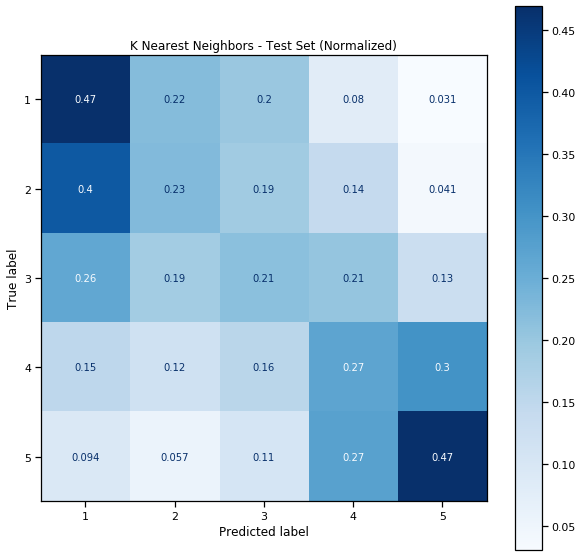

In [56]:
y_hat_knn_test = clf_knn.predict(X_test_numeric)
print(classification_report(y_test, y_hat_knn_test))
show_confusion_matrix(clf_knn, X_test_numeric, y_test, title='K Nearest Neighbors - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='#decisiontrees'></a>
### Decision Trees

              precision    recall  f1-score   support

           1       0.82      1.00      0.90     11142
           2       1.00      0.93      0.96     11142
           3       0.99      0.92      0.96     11142
           4       0.97      0.94      0.95     11142
           5       0.96      0.92      0.94     11142

    accuracy                           0.94     55710
   macro avg       0.95      0.94      0.94     55710
weighted avg       0.95      0.94      0.94     55710



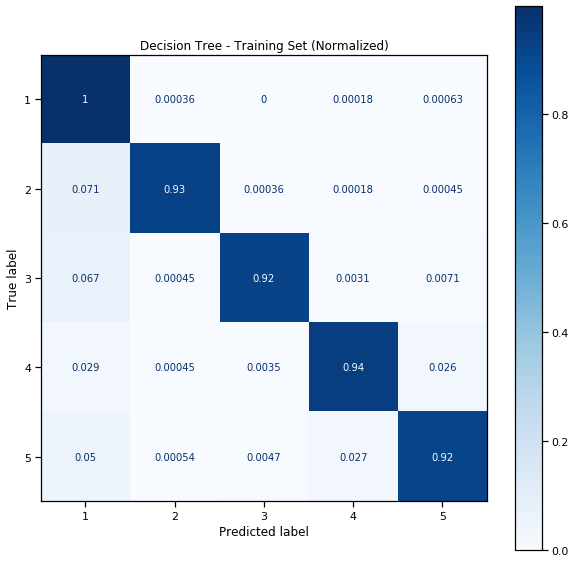

In [96]:
clf_dt = DecisionTreeClassifier(criterion='entropy')
clf_dt.fit(X_train_resampled, y_train_resampled)

y_hat_dt_train = clf_dt.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_dt_train))
show_confusion_matrix(clf_dt, X_train_resampled, y_train_resampled, title='Decision Tree - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.27      0.43      0.33       578
           2       0.12      0.16      0.13       367
           3       0.13      0.18      0.15       531
           4       0.19      0.22      0.21      1107
           5       0.74      0.58      0.65      3667

    accuracy                           0.44      6250
   macro avg       0.29      0.31      0.29      6250
weighted avg       0.51      0.44      0.47      6250



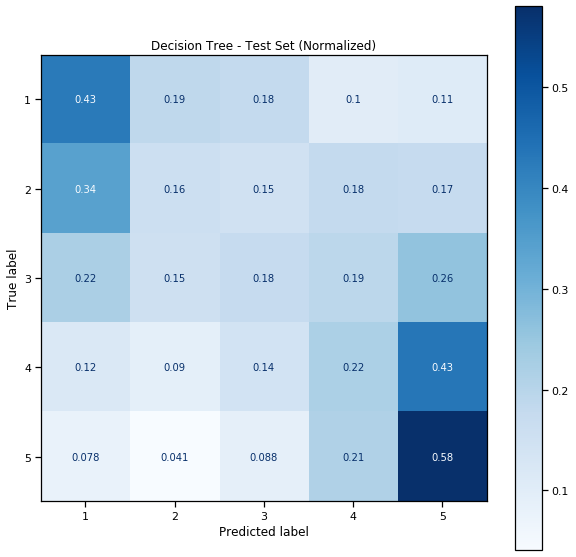

In [97]:
y_hat_dt_test = clf_dt.predict(X_test_numeric)
print(classification_report(y_test, y_hat_dt_test))
show_confusion_matrix(clf_dt, X_test_numeric, y_test, title='Decision Tree - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='#baggedtrees'></a>
### Bagged Trees

              precision    recall  f1-score   support

           1       0.52      0.63      0.57     11142
           2       0.49      0.48      0.49     11142
           3       0.42      0.40      0.41     11142
           4       0.38      0.31      0.34     11142
           5       0.55      0.58      0.56     11142

    accuracy                           0.48     55710
   macro avg       0.47      0.48      0.47     55710
weighted avg       0.47      0.48      0.47     55710



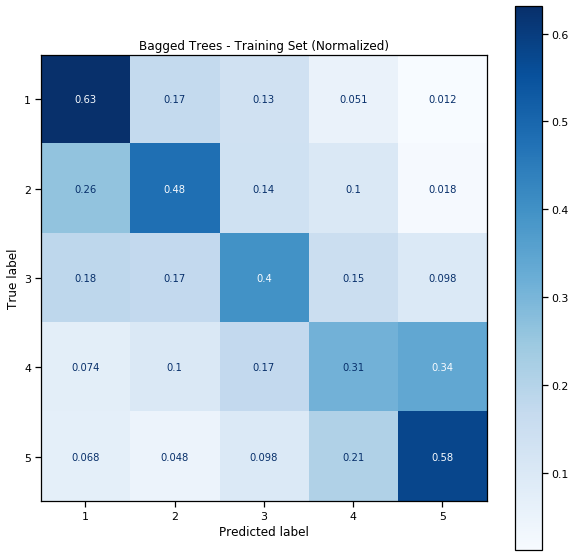

In [59]:
clf_bagged = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_leaf_nodes=100), 
                                 n_estimators=20)
clf_bagged.fit(X_train_resampled, y_train_resampled)

y_hat_bagged_train = clf_bagged.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_bagged_train))
show_confusion_matrix(clf_bagged, X_train_resampled, y_train_resampled, title='Bagged Trees - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.32      0.53      0.40       578
           2       0.13      0.22      0.16       367
           3       0.17      0.27      0.21       531
           4       0.26      0.30      0.28      1107
           5       0.83      0.58      0.68      3667

    accuracy                           0.48      6250
   macro avg       0.34      0.38      0.35      6250
weighted avg       0.59      0.48      0.51      6250



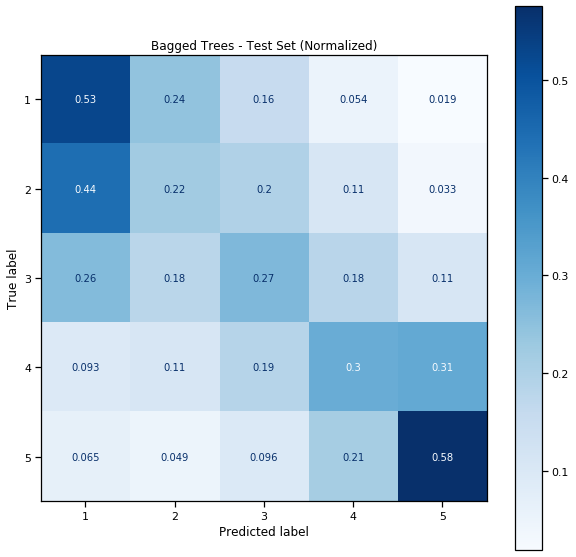

In [60]:
y_hat_bagged_test = clf_bagged.predict(X_test_numeric)
print(classification_report(y_test, y_hat_bagged_test))
show_confusion_matrix(clf_bagged, X_test_numeric, y_test, title='Bagged Trees - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='randomforest'></a>
### Random Forest

              precision    recall  f1-score   support

           1       0.77      0.94      0.84     11142
           2       0.89      0.88      0.89     11142
           3       0.91      0.82      0.86     11142
           4       0.87      0.78      0.82     11142
           5       0.81      0.82      0.82     11142

    accuracy                           0.85     55710
   macro avg       0.85      0.85      0.85     55710
weighted avg       0.85      0.85      0.85     55710



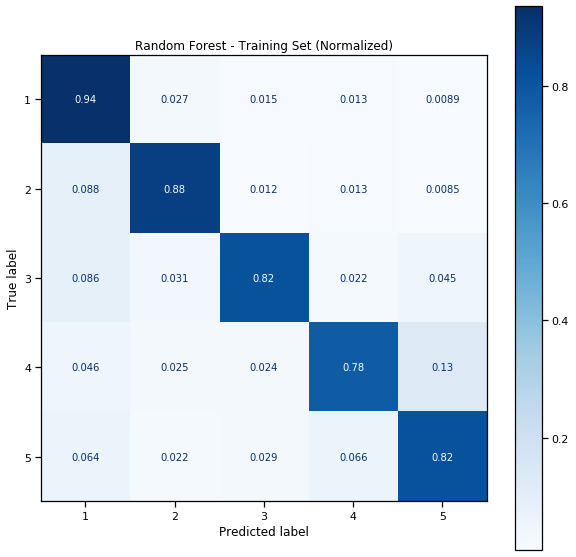

In [113]:
clf_forest = RandomForestClassifier(n_estimators=100, max_depth = 15)
clf_forest.fit(X_train_resampled, y_train_resampled)

y_hat_forest_train = clf_forest.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_forest_train))
show_confusion_matrix(clf_forest, X_train_resampled, y_train_resampled, title='Random Forest - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.29      0.49      0.36       578
           2       0.13      0.20      0.16       367
           3       0.15      0.20      0.17       531
           4       0.22      0.21      0.21      1107
           5       0.78      0.63      0.70      3667

    accuracy                           0.48      6250
   macro avg       0.31      0.34      0.32      6250
weighted avg       0.54      0.48      0.50      6250



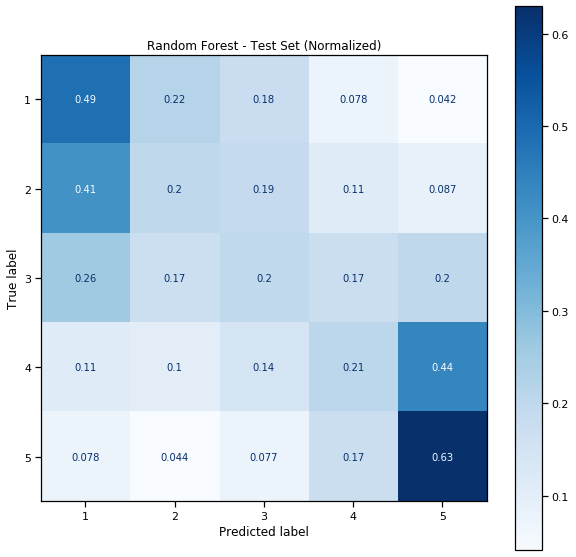

In [112]:
y_hat_forest_test = clf_forest.predict(X_test_numeric)
print(classification_report(y_test, y_hat_forest_test))
show_confusion_matrix(clf_forest, X_test_numeric, y_test, title='Random Forest - Test Set (Normalized)')



[Back to Top ↑](#top)

<a id='adaboost'></a>
### Adaboost

              precision    recall  f1-score   support

           1       0.44      0.58      0.50     11142
           2       0.33      0.33      0.33     11142
           3       0.33      0.18      0.23     11142
           4       0.33      0.36      0.35     11142
           5       0.55      0.56      0.55     11142

    accuracy                           0.40     55710
   macro avg       0.39      0.40      0.39     55710
weighted avg       0.39      0.40      0.39     55710



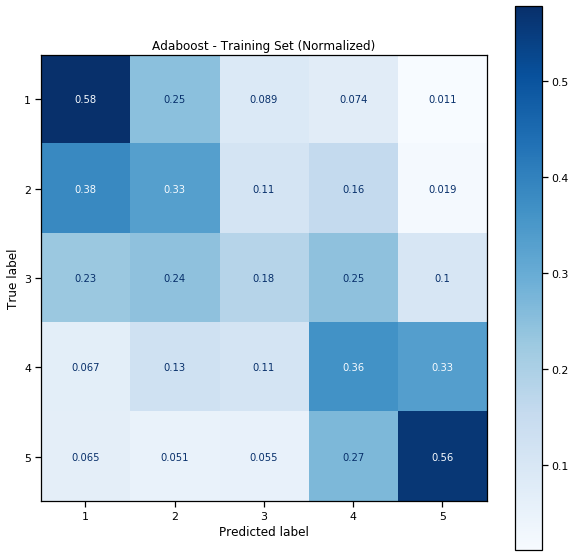

In [63]:
clf_ab = AdaBoostClassifier()
clf_ab.fit(X_train_resampled, y_train_resampled)

y_hat_ab_train = clf_ab.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_hat_ab_train))
show_confusion_matrix(clf_ab, X_train_resampled, y_train_resampled, title='Adaboost - Training Set (Normalized)')

In [64]:
y_hat_ab_test = clf_ab.predict(X_test_numeric)
print(classification_report(y_test, y_hat_ab_test))
show_confusion_matrix(clf_ab, X_test_numeric, y_test, title='Adaboost - Test Set (Normalized)')

              precision    recall  f1-score   support

           1       0.37      0.58      0.45       578
           2       0.15      0.32      0.21       367
           3       0.15      0.14      0.14       531
           4       0.24      0.35      0.29      1107
           5       0.83      0.56      0.67      3667

    accuracy                           0.48      6250
   macro avg       0.35      0.39      0.35      6250
weighted avg       0.59      0.48      0.51      6250





[Back to Top ↑](#top)

<a id='gradientboost'></a>
### Gradient Boost

In [65]:
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train_resampled, y_train_resampled)

y_hat_gb_train = clf_gb.predict(X_train_resampled)

print(classification_report(y_train_resampled, y_hat_gb_train))
show_confusion_matrix(clf_gb, X_train_resampled, y_train_resampled, title='Gradient Boost - Training Set (Normalized)')

              precision    recall  f1-score   support

           1       0.49      0.61      0.55     11142
           2       0.44      0.44      0.44     11142
           3       0.41      0.32      0.36     11142
           4       0.40      0.37      0.38     11142
           5       0.57      0.60      0.58     11142

    accuracy                           0.47     55710
   macro avg       0.46      0.47      0.46     55710
weighted avg       0.46      0.47      0.46     55710



In [66]:
y_hat_gb_test = clf_gb.predict(X_test_numeric)
print(classification_report(y_test, y_hat_gb_test))
show_confusion_matrix(clf_gb, X_test_numeric, y_test, title='Gradient Boost - Test Set (Normalized)')

              precision    recall  f1-score   support

           1       0.34      0.57      0.43       578
           2       0.14      0.27      0.19       367
           3       0.16      0.20      0.18       531
           4       0.24      0.27      0.25      1107
           5       0.82      0.59      0.68      3667

    accuracy                           0.48      6250
   macro avg       0.34      0.38      0.35      6250
weighted avg       0.57      0.48      0.51      6250





[Back to Top ↑](#top)

<a id='countvectorization'></a>
### Improved Results through Count Vectorization

In addition to our experiments with VADER, we also tried Count Vectorization, collecting the universal set of every word appearing in a review in our sample, and then transforming each review into a sparsely populated vector counting the number of times each word in the universal set occurs in that review so that we could use these vectors as predictors.

When run using a train-test split of all 960,000 reviews in our watches dataset, this method yielded better results in terms of generalizability, giving us 71% accuracy for Logistic Regression against both the training set and the test set. The downside was that it was incredibly slow and required a vast amount of memory, frequently forcing the kernel to restart before processing completed.

Results were not as strong when working with the much smaller 20,000-25,000 review random sample used for the rest of our analysis. Note the 20% score gap between training set and test set below, indicating a strong possibility of overfitting once again.

In [67]:
X_train_vector, X_test_vector = get_vectorized_features(X_train, X_test)

In [68]:
lr = LogisticRegression(penalty = 'l2')
lr.fit(X_train_vector, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
lr.score(X_train_vector, y_train)

0.8781333333333333

In [70]:
lr.score(X_test_vector, y_test)

0.66768

<a id='visualizations'></a>
### Visualizations

The visualizations below help to illustrate how the words and phrases in different classes of reviews differ from each other.

### Word Cloud for 5-Star Reviews

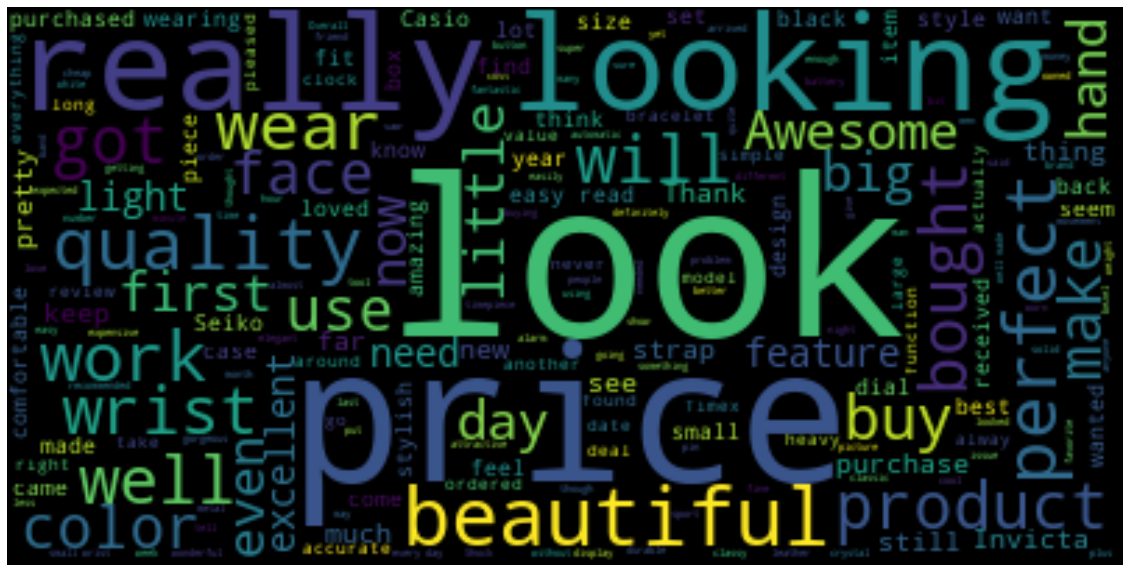

In [26]:
n_star_review_wordcloud(df, 5)

### Word Cloud for 3-Star Reviews


In [27]:
n_star_review_wordcloud(df, 3)

### Word Cloud for 1-Star Reviews


In [28]:
n_star_review_wordcloud(df, 1)


[Back to Top ↑](#top)

<a id='recommendations'></a>
### Recommendations & Next Steps

Through our analysis we've established the starting point for a framework by which the text of an Amazon review text can be used to predict the star rating associated with that review. Significant work remains in terms of improving the generalizability of these predictions so that they perform with a high degree of accuracy on new data outside of the training set. 

To accomplish this, we will continue to tune our models to find the optimal parameters and also seek to test additional models such as XGBoost, SVC, and Kernel Approximation. Given the promise shown by our Count Vectorization experiments, continuing to explore that method and other NLP techniques should be helpful in continuing to improve the performance of our models.

Further, we will seek to work with additional categories of data, and also explore the possibility of predicting only whether a review is "good" (4 or 5 stars) or "bad" (1 or 2 stars), which may be just as valuable or more valuable to a business as knowing the precise star rating.

Our eventual goal is that our process can be deployed on customer conversations anywhere, in any form, allowing businesses to proceed up with the appropriate automated customer service response (either internal to the business or directly to the customer), based on the class of the message and perhaps other contextual data that may provide further clues and insights.



[Back to Top ↑](#top)